In [1]:
import torch
import pickle
import os,sys
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../../")

from human_aware_rl.rllib.rllib import reset_dummy_policy, gen_trainer_from_params
from human_aware_rl.rllib.utils import get_base_ae
from human_aware_rl.dummy.rl_agent import *
from overcooked_ai_py.agents.agent import AgentPair

In [2]:
def load_checkpoint(file_path):
    assert os.path.isfile(file_path)
    with open(file_path, 'rb') as file:
        checkpoint = pickle.load(file)
    return checkpoint["reward_model"], checkpoint['config'], checkpoint['expert_svf']


def run_rl_training(params):
    # Retrieve the tune.Trainable object that is used for the experiment
    trainer = gen_trainer_from_params(params)
    # Object to store training results in
    result = {}

    # Training loop
    for i in range(params['num_training_iters']):
        result = trainer.train()

        msg = result['episode_reward_mean']
        msg2 = result['episode_reward_max']
        msg3 = result['episode_reward_min']
        if i % 10 == 0:
            print(f'{i}: ep rew mean={msg}, max={msg2}, min={msg3}')
        trainer.workers.foreach_worker(lambda ev: reset_dummy_policy(ev.get_policy('dummy')))
    
    return result

def getVisitation(states, joint_action, env):
    target_player_idx = 0
    num_game = len(states)
    freq = {}
    for game, actions in zip(states,joint_action):
        for s,a in zip(game,actions):
            reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
            reward_features = tuple(reward_features)
            if reward_features not in freq:
                freq[reward_features] = 0
            freq[reward_features] += 1
    
    for state in freq:
        freq[state] /= num_game
    return freq

def getExpertStateFeatures(train_config, left_agent, right_agent):
    mdp_params = train_config["environment_params"]["mdp_params"]
    env_params = train_config["environment_params"]["env_params"]
    ae = get_base_ae(mdp_params, env_params)
    env = ae.env


    agent_pair = AgentPair(left_agent, right_agent)
    results = env.get_rollouts(agent_pair=agent_pair, num_games=1, display=False)
    states = results['ep_states']
    actions = results['ep_actions']

    act = []
    for idx in actions[0]:
        act.append([Action.ACTION_TO_INDEX[idx[0]], Action.ACTION_TO_INDEX[idx[1]]])
    actions = act
    states = states[0]

    target_player_idx = 0
    features = []    
    for s,a in zip(states,actions):
        reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
        features.append(reward_features)
    return features

def getAgentVisitation(train_config, env): #get the feature expectations of a new policy using RL agent
    '''
    Trains an RL agent with the current reward function. 
    Then rolls out one trial of the trained agent and calculate the feature expectation of the RL agent.
    - train_config: the configuration taken by the rllib trainer
    
    Returns the feature expectation.
    '''
    # train and get rollouts
    try:
        results = run_rl_training(train_config)
        states = results['evaluation']['states']
        actions = results['evaluation']['actions']
        scores = results['evaluation']['sparse_reward']
        actions = _convertAction2Index(actions)
        state_visit = getVisitation(states, actions, env)
        return state_visit
    except Exception as e:
        print('ERROR: could not get Agent Visitation. --> ' + str(e))

def min_max_scale(a, b=None):
    # apply min-max scaling, range becomes [0,1]
    if b is None:
        mini = torch.min(a)
        maxi = torch.max(a)
        a = (a - mini) / (maxi - mini)
        return a
    else:
        mini = min(torch.min(a), torch.min(b))
        maxi = max(torch.max(a), torch.max(b))
        a = (a - mini) / (maxi - mini)
        b = (b - mini) / (maxi - mini)
        return a,b

In [38]:
ltn_ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T3_latino/epoch=20.checkpoint"
wte_ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T3_white/epoch=30.checkpoint"
coop_ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T27_coop/epoch=30.checkpoint"
noncoop_ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T27_noncoop/epoch=40.checkpoint"

ltn_reward_model, ltn_config, ltn_state_visit = load_checkpoint(ltn_ckpt)
wte_reward_model, wte_config, wte_state_visit = load_checkpoint(wte_ckpt)
cp_reward_model, cp_config, cp_state_visit = load_checkpoint(coop_ckpt)
ncp_reward_model, ncp_config, ncp_state_visit = load_checkpoint(noncoop_ckpt)

In [39]:
COOP_BOT_SVF = getExpertStateFeatures(cp_config, MAICooperativeAgent(), MAIDummyRightCoopAgent())
NONCOOP_BOT_SVF = getExpertStateFeatures(ncp_config, MAINonCoopAgent(), MAIDummyRightCoopAgent())

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 5.00; : 100%|██████████| 1/1 [00:00<00:00, 167.66it/s]


Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 8.00; : 100%|██████████| 1/1 [00:00<00:00, 196.60it/s]

Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


In [40]:

def get_stats(reward_model, states):
    lst = []
    for state in states:
        reward = reward_model.get_rewards(state)
        lst.append(reward[0].item())
    lst = torch.tensor(lst)
    return lst

ltn_cp = get_stats(ltn_reward_model, COOP_BOT_SVF)[:5]
ltn_np = get_stats(ltn_reward_model, NONCOOP_BOT_SVF)

wte_cp = get_stats(wte_reward_model, COOP_BOT_SVF)[:5]
wte_np = get_stats(wte_reward_model, NONCOOP_BOT_SVF)

cp_cp = get_stats(cp_reward_model, COOP_BOT_SVF)[:5]
cp_np = get_stats(cp_reward_model, NONCOOP_BOT_SVF)

ncp_cp = get_stats(ncp_reward_model, COOP_BOT_SVF)[:5]
ncp_np = get_stats(ncp_reward_model, NONCOOP_BOT_SVF)

In [41]:
def min_max_scale_with_avg(a, b):
    # apply min-max scaling, range becomes [0,1]
    mini = min(torch.min(a), torch.min(b))
    maxi = max(torch.max(a), torch.max(b))
    a = torch.sum((a - mini) / (maxi - mini)) / len(a)
    b = torch.sum((b - mini) / (maxi - mini)) / len(b)
    return a,b

# scaled average reward per step
avg_ltn_cp, avg_ltn_np = min_max_scale_with_avg(ltn_cp, ltn_np)
avg_wte_cp, avg_wte_np = min_max_scale_with_avg(wte_cp, wte_np)
avg_coop_cp, avg_coop_np = min_max_scale_with_avg(cp_cp, cp_np)
avg_noncoop_cp, avg_noncoop_np = min_max_scale_with_avg(ncp_cp, ncp_np)

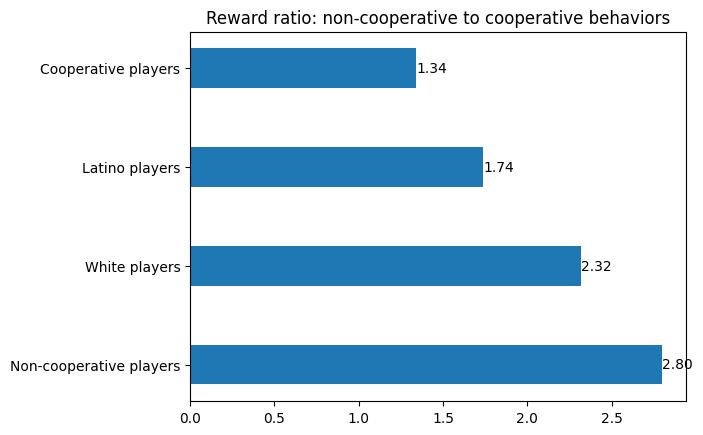

In [42]:
width = 0.2
ratio = [avg_noncoop_np / avg_noncoop_cp, avg_wte_np / avg_wte_cp, avg_ltn_np / avg_ltn_cp, avg_coop_np / avg_coop_cp]
ind = 0.5 * np.arange(4)
label = ['Non-cooperative players', 'White players','Latino players', 'Cooperative players']

fig, ax = plt.subplots()
bar = ax.barh(ind + 0.5 * width, ratio, width) #, color=['olive', 'peru'])

ratio = ["{:.2f}".format(round(r.item(), 2)) for r in ratio]
plt.bar_label(bar, ratio)

# ax.barh(ind, [coop_noncoop], width, color='olive', label='non-cooperative reward')

ax.set(yticks=ind + 0.5*width, yticklabels=label) #, ylim=[width - 0.6, 1.1])
ax.set_title('Reward ratio: non-cooperative to cooperative behaviors')
plt.show()

# Plotting reward per feature

In [6]:
FEATURES = [
    'p0 onion dx', 'p0 onion dy', 
    'p0 bridge dx', 'p0 bridge dy', 
    'p0 stove dx', 'p0 stove dy', 
    'p0 orientation(N)', 'p0 orientation(S)', 'p0 orientation(E)', 'p0 orientation(W)',  
    'p0 withOnion', 
    'p1 withOnion',
    'onion on bridge',
    'No. of onion in pot',
    'p0 at (4,3) w/ onion',
    'p0 at (4,2) w/ onion',
    'p0 at (4,1) w/ onion',
    'p0 at (3,1) w/ onion',
    ]

feat = torch.diag(torch.ones(18))

ltn_rew_per_feat = ltn_reward_model.get_rewards(feat).squeeze()
wte_rew_per_feat = wte_reward_model.get_rewards(feat).squeeze()
ncp_reward_per_feat = ncp_reward_model.get_rewards(feat).squeeze()
cp_reward_per_feat = cp_reward_model.get_rewards(feat).squeeze()

ltn_rew_per_feat = min_max_scale(ltn_rew_per_feat)
wte_rew_per_feat = min_max_scale(wte_rew_per_feat)
ncp_reward_per_feat = min_max_scale(ncp_reward_per_feat)
cp_reward_per_feat = min_max_scale(cp_reward_per_feat)

for rew in [ltn_rew_per_feat, wte_rew_per_feat, ncp_reward_per_feat, cp_reward_per_feat]:   
    for i in range(4):
        rew[i] = -1 * rew[i]


In [26]:
import numpy as np 

def plot_bar(rewards1, rewards2,rewards3, rewards4, features, title):
    bar_labels_1 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards1]
    bar_labels_2 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards2]
    bar_labels_3 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards3]
    bar_labels_4 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards4]
    plt.clf()

    plt.figure() 

    n = len(features)
    r = np.arange(n)
    height = 0.5

    bar_1 = plt.barh(r * 4 * height, rewards1, label="latino", height=0.4)
    bar_2 = plt.barh(r * 4 * height + height, rewards2, label="white", height=0.4)
    bar_3 = plt.barh(r * 4 * height + height * 2, rewards3, label="non-coop", height=0.4)
    bar_4 = plt.barh(r * 4 * height + height * 3, rewards4, label="coop", height=0.4)
    plt.xlim([-0.5, 1.2])
    plt.bar_label(bar_1, bar_labels_1)
    plt.bar_label(bar_2, bar_labels_2)
    plt.bar_label(bar_3, bar_labels_3)
    plt.bar_label(bar_4, bar_labels_4)
    plt.yticks(r * 4 * height + 1.5 * height, features)
    plt.legend()
    plt.title(title)
    # plt.plot()
    plt.show
    # plt.savefig('t20_human_reward_comparison.pdf', format='pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

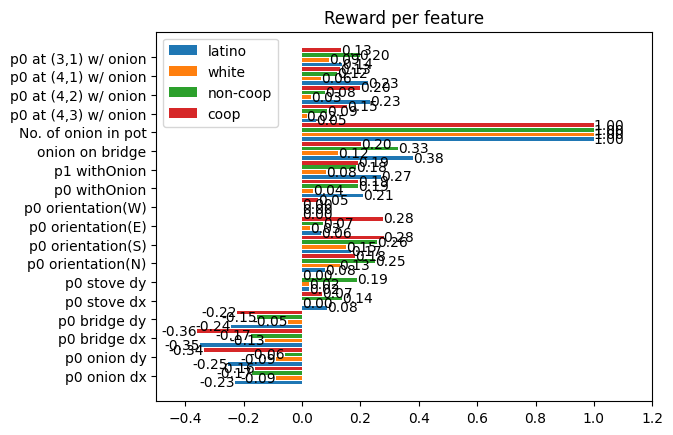

In [28]:
plot_bar(ltn_rew_per_feat, wte_rew_per_feat, ncp_reward_per_feat, cp_reward_per_feat, FEATURES, "Reward per feature")

<Figure size 640x480 with 0 Axes>

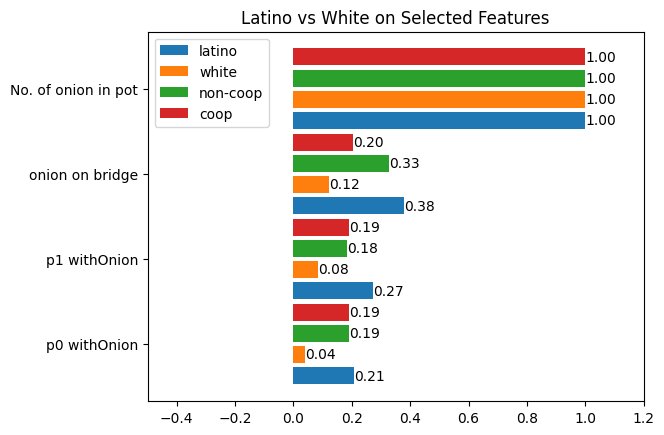

In [27]:
selected_feat_idx = [10, 11, 12, 13]
feature_label = [FEATURES[i] for i in selected_feat_idx]
latino = [ltn_rew_per_feat[i] for i in selected_feat_idx]
white = [wte_rew_per_feat[i] for i in selected_feat_idx]
coop = [cp_reward_per_feat[i] for i in selected_feat_idx]
noncoop = [ncp_reward_per_feat[i] for i in selected_feat_idx]

plot_bar(latino, white, noncoop, coop, feature_label, "Latino vs White on Selected Features")

